<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 1</h1>

**Learn to develop your own architecture for image classification task**

# Getting the data
Using CIFAR 10 

In [1]:
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

In [2]:
cifar_10 = keras.datasets.cifar10.load_data()

In [3]:
train_all, test = cifar_10
X_train_all,y_train_all = train_all
X_test, y_test = test
X_train,X_valid,y_train,y_valid = train_test_split(X_train_all,y_train_all,train_size=0.9,stratify=y_train_all)

class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
]

sets = ['tr','va','te']
TR,VA,TE = sets

# Scale images from 0 to 1
X = {s:d.copy()/255 for s,d in zip(sets,[X_train,X_valid,X_test])}
y = {s:d.copy().squeeze() for s,d in zip(sets,[y_train,y_valid,y_test])}


print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(45000, 32, 32, 3) (45000, 1) (5000, 32, 32, 3) (5000, 1) (10000, 32, 32, 3) (10000, 1)


**View the data**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

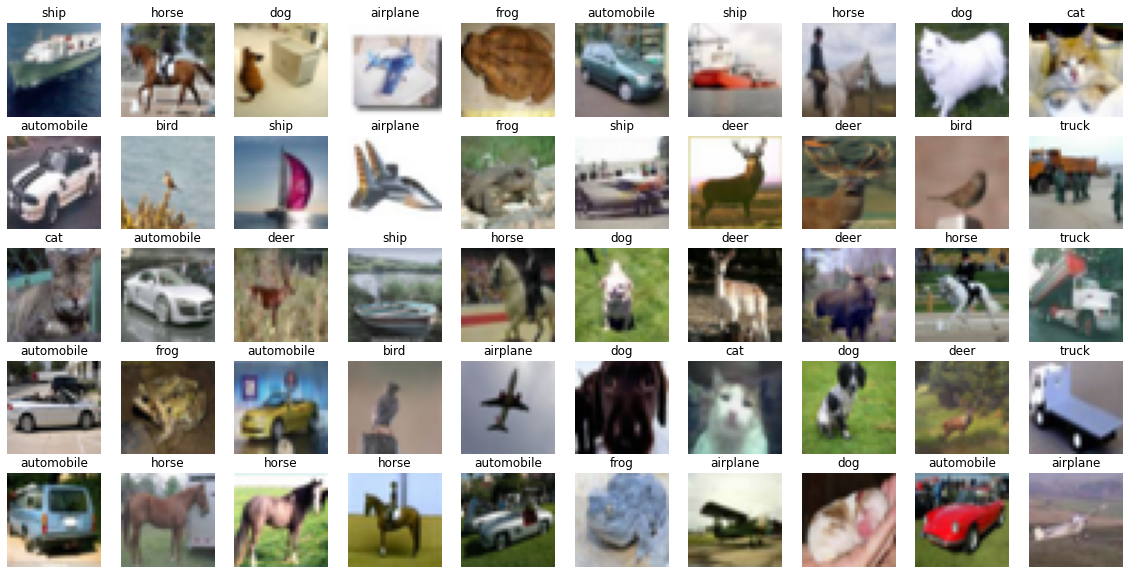

In [5]:
r,c = 5,10
plt.figure(figsize=(20,10))

r_idx = np.random.randint(0,len(y_train),(r*c,))
for i in range(r*c):
    idx = r_idx[i]
    label = class_labels[y_train[idx].item()]
    plt.subplot(r,c,i+1)
    plt.imshow(X_train[idx])
    plt.axis('off')
    plt.title(label)
plt.show() 

# Create Dataset and Dataloader
For use with pytorch

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [268]:
tf = lambda d: torch.tensor(d, dtype=torch.float32)
ti = lambda d: torch.tensor(d, dtype=torch.long)

dl = {s: DataLoader(TensorDataset(tf(X[s].transpose(0,3,1,2)), ti(y[s])),batch_size=64,shuffle=True) for s in sets}

___

# Define a network

## Pytorch Implementation

In [303]:
import time
from copy import deepcopy

from torch import nn
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Model Definition

In [145]:
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BasicConv(3, 32, 7)
        self.maxp1 = nn.MaxPool2d(3, 1)
        self.conv2 = BasicConv(32, 96, 1)
        self.conv3 = BasicConv(96, 192, 3)
        self.maxp2 = nn.MaxPool2d(3, 1)

    def forward(self, x):
        x = self.conv1(x)  # (32,26,26)
        x = self.maxp1(x)  # (32,24,24)
        x = self.conv2(x)  # (96,24,24)
        x = self.conv3(x)  # (192,22,22)
        x = self.maxp2(x)  # (192,20,20)
        return x
    
class IncepSkipBlock(nn.Module):
    def __init__(self, in_channel, out_channels):
        super().__init__()
        self.branch0 = BasicConv(in_channel, out_channels[0], 1)

        self.branch1 = nn.Sequential(
            BasicConv(in_channel, out_channels[1], 1,padding=1),
            BasicConv(out_channels[1], out_channels[3], 3)
        )

        self.branch2 = nn.Sequential(
            BasicConv(in_channel, out_channels[2], 1, padding=2),
            BasicConv(out_channels[2], out_channels[4], 5)
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, 1,padding=1),
            BasicConv(in_channel, out_channels[5], 1)
        )

    def forward(self, x):
        x_0 = self.branch0(x)
        x_1 = self.branch1(x)
        x_2 = self.branch2(x)
        x_3 = self.branch3(x)
        x = torch.cat([x,x_0,x_1,x_2,x_3],dim=1)
        return x
        
class LameNet(nn.Module):
    def __init__(self,classes=10):
        super().__init__()
        self.stem = Stem()
        self.block1 = IncepSkipBlock(192,[32,64,16,96,32,32])
        self.pblock1 = nn.Sequential(
            BasicConv(384,256,1),
            nn.MaxPool2d(3,2)
        )
        self.block2 = IncepSkipBlock(256,[64,128,32,192,64,64])
        self.pblock2 = nn.Sequential(
            BasicConv(640,512,1),
            nn.MaxPool2d(3,2)
        )
        self.conv3_1 = BasicConv(512,1024,3,1)
        self.linear = nn.Linear(4096,classes)
        self.logits = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.pblock1(x)
        x = self.block2(x)
        x = self.pblock2(x)
        x = self.conv3_1(x)
        x = self.linear(x.view(x.size(0),-1))
        x = self.logits(x)
        return x

In [150]:
model_pt = LameNet()
summary(model_pt,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           4,736
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         BasicConv-4           [-1, 32, 26, 26]               0
         MaxPool2d-5           [-1, 32, 24, 24]               0
            Conv2d-6           [-1, 96, 24, 24]           3,168
       BatchNorm2d-7           [-1, 96, 24, 24]             192
              ReLU-8           [-1, 96, 24, 24]               0
         BasicConv-9           [-1, 96, 24, 24]               0
           Conv2d-10          [-1, 192, 22, 22]         166,080
      BatchNorm2d-11          [-1, 192, 22, 22]             384
             ReLU-12          [-1, 192, 22, 22]               0
        BasicConv-13          [-1, 192, 22, 22]               0
        MaxPool2d-14          [-1, 192,

In [426]:
def fit(model, optim, sched, loss_func, dl, epochs=100, is_test=False):
    model = model.to(device)
    phases = [TR, VA]
    tot_time = time.time()
    losses = {
        TR:[],
        VA:[]
    }
    accuracies = {
        TR:[],
        VA:[]
    }
    sizes = {ph: len(dl[ph].dataset) for ph in phases}
    
    least_loss = float('inf')
    best_accu = 0
    best_model = deepcopy(model.state_dict())
    
    for e in range(epochs):
        epo_time = time.time()
        epoch_st = f"[{e+1}/{epochs}]".rjust(len(str(epochs))*2+3)
        print(f"{epoch_st} | ",end="")
        
        for phase in phases:
            running_loss = 0
            running_corr = 0
            is_tr = phase == TR
            
            for b_num,batch in enumerate(dl[phase]):
                X,y = batch
                bs = len(y)
                X = X.to(device)
                y = y.to(device)
                
                if is_test:
                    if is_tr:
                        if b_num == 1:
                            break
                    elif not is_tr and b_num == 2:
                        break
                    else:
                        pass
                    
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):
                    y_pred = model(X)
                    loss = loss_func(y_pred,y)
                    if is_tr:
                        loss.backward()
                        optim.step()
                        
                    if not is_tr:
                        sched.step(loss)
                        
                
                    batch_loss = loss.item() * bs
                    batch_corr = (y_pred.argmax(dim=1) == y).sum().item()
                    
                    running_loss += batch_loss
                    running_corr += batch_corr
                    
            epo_loss = running_loss / sizes[phase]
            epo_accu = running_corr / sizes[phase]
            print(f"{phase} :: loss: {epo_loss:0.4f} accu: {epo_accu:0.4f} | ", end="")
            
            losses[phase].append(epo_loss)
            accuracies[phase].append(epo_accu)
            
            if not is_tr:
                if epo_accu > best_accu:
                    best_accu = epo_accu
            
                if epo_loss < least_loss:
                    least_loss = epo_loss
                    best_model = deepcopy(model.state_dict())
            
            
        end_time = np.round(time.time() - epo_time,3)
        s,ms = str(end_time).split('.')
        print(f"time {s} s {ms} ms")
    end_time = np.round(time.time() - tot_time,3)
    s,ms = str(end_time).split('.')
    print(f"best accuracy: {best_accu:0.4f} least loss: {least_loss:0.4f}")
    print(f"time {int(s)//60} m {int(s)%60} s {ms} ms")
    return losses, accuracies

**Define trainers**

In [427]:
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_pt.parameters(),)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,threshold=1e-4)

**Fit**  
*Test run*

In [428]:
_ = fit(model_pt, optim, sched, loss_func, dl, epochs=9, is_test=True)

[1/9] | tr :: loss: 0.0032 accu: 0.0003 | va :: loss: 0.0544 accu: 0.0082 | time 5 s 46 ms
[2/9] | tr :: loss: 0.0029 accu: 0.0006 | va :: loss: 0.0557 accu: 0.0072 | time 4 s 865 ms
[3/9] | tr :: loss: 0.0031 accu: 0.0004 | va :: loss: 0.0536 accu: 0.0096 | time 4 s 919 ms
[4/9] | tr :: loss: 0.0030 accu: 0.0005 | va :: loss: 0.0532 accu: 0.0100 | time 5 s 019 ms
[5/9] | tr :: loss: 0.0030 accu: 0.0006 | va :: loss: 0.0548 accu: 0.0080 | time 5 s 012 ms
[6/9] | tr :: loss: 0.0030 accu: 0.0005 | va :: loss: 0.0538 accu: 0.0096 | time 5 s 05 ms
[7/9] | tr :: loss: 0.0030 accu: 0.0005 | va :: loss: 0.0551 accu: 0.0082 | time 4 s 946 ms
[8/9] | tr :: loss: 0.0031 accu: 0.0004 | va :: loss: 0.0548 accu: 0.0086 | time 4 s 947 ms
[9/9] | tr :: loss: 0.0031 accu: 0.0004 | va :: loss: 0.0547 accu: 0.0080 | time 4 s 973 ms
best accuracy: 0.0100 least loss: 0.0532
time 0 m 45 s 202 ms


*Actual run*

In [ ]:
losses,accuracies = fit(model_pt, optim, sched, loss_func, dl, epochs=100, is_test=False)

**Test**

In [466]:
def check_accu(model, dl_test):
    model = model.to(device)
    model.eval()
    
    bs = dl_test.batch_size
    size = len(dl_test.dataset)
    iters = size//bs//50
    
    corrects = 0
    losses = 0
    print("[",end="")
    for i,batch in enumerate(dl_test):
        with torch.no_grad():
            X,y = batch
            if i+1 %iters:
                print("-",end="")

            b = len(y)
            X = X.to(device)
            y = y.to(device)
            y_ = model(X)

            losses += loss_func(y_,y) * b
            corrects += (y_.argmax(dim=1)==y).sum().item()
    print("]")
    loss, accu = losses/size, corrects/size
    print(f"loss: {loss:0.4f} accuracy: {accu:0.4f}")
    return loss, accu

In [ ]:
check_accu(model_pt, dl[TE])

[-------------------------------------------

___

## Keras Implementation

In [155]:
import pandas as pd
from tensorflow.keras import layers, activations, optimizers, losses, callbacks

### Model Definition

In [182]:
def basic_conv(name, out_channels, kernel_size, stride=1, padding='valid'):
    return keras.Sequential([
        layers.Conv2D(out_channels,kernel_size, stride,padding,activation=None),
        layers.BatchNormalization(),
        layers.ReLU()
    ],name)

def stem():
    return keras.Sequential([
        basic_conv("conv_7_1",32,7),
        layers.MaxPool2D((3,3),1),
        basic_conv("conv_1_1",96,1),
        basic_conv("conv_3_1",192,3),
        layers.MaxPool2D((3,3),1)
    ],name="stem")

def incep_skip_block(input_shape, out_channels, name):
    branch0 = basic_conv("conv_1_1",out_channels[0],1)
    branch1 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[1],1),
        basic_conv("conv_1_2",out_channels[3],3, padding='same')
        
    ])
    branch2 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[2],1),
        basic_conv("conv_1_2",out_channels[4],5, padding='same')
    ])
    branch3 = keras.Sequential([
        layers.MaxPool2D((3,3),strides=1,padding='same'),
        basic_conv("conv_1_2",out_channels[5],1)
    ])
    input_ = layers.Input(shape=input_shape)
    b0_out = branch0(input_)
    b1_out = branch1(input_)
    b2_out = branch2(input_)
    b3_out = branch3(input_)
    output_ = layers.concatenate([input_,b0_out,b1_out,b2_out,b3_out])
    return keras.Model(inputs=[input_],outputs=[output_],name=name)

def post_block(out_channels,name):
    return keras.Sequential([
        basic_conv("conv_1_1",out_channels,1),
        layers.MaxPool2D((3,3),2)
    ],name)

def lame_net(classes=10,name="lame_net"):
    input_ = layers.Input(shape=(32,32,3))
    stem_ = stem()(input_)
    
    isblock1 = incep_skip_block((20,20,192),[32,64,16,96,32,32],'incep_skip_1')(stem_)
    pblock1 = post_block(256,'pblock_1')(isblock1)
    
    isblock2 = incep_skip_block((9,9,256),[64,128,32,192,64,64],'incep_skip_2')(pblock1)
    pblock2 = post_block(512,'pblock_2')(isblock2)
    
    conv3_1 = basic_conv("conv_3_1",1024,3)(pblock2)
    flatten = layers.Flatten()(conv3_1)
    layers.Dropout(rate=0.4)()
    softmax = layers.Dense(10,activation='softmax')(flatten)
    return keras.Model(inputs=[input_],outputs=[softmax],name=name)

In [184]:
model_ke = lame_net(10,"lame_net")
model_ke.summary()

Model: "lame_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem (Sequential)            (None, 20, 20, 192)       175264    
_________________________________________________________________
incep_skip_1 (Model)         (None, 20, 20, 384)       97104     
_________________________________________________________________
pblock_1 (Sequential)        (None, 9, 9, 256)         99584     
_________________________________________________________________
incep_skip_2 (Model)         (None, 9, 9, 640)         348832    
_________________________________________________________________
pblock_2 (Sequential)        (None, 4, 4, 512)         330240    
_________________________________________________________________
conv_3_1 (Sequential)        (None, 2, 2, 1024)        472

**Compile the model**

In [185]:
model_ke.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Ready the data (alter shapes for keras)**

In [191]:
X_for_keras = lambda X:X.transpose(0,1,2,3)
y_for_keras = lambda y:y.squeeze()

X_ke = {s: X_for_keras(X[s]) for s in sets}
y_ke = {s: y_for_keras(y[s]) for s in sets}

**Callbacks**

In [288]:
lr_scheduler_cb = callbacks.ReduceLROnPlateau(min_delta=1e-4)
early_stopping_cb = callbacks.EarlyStopping(min_delta=0.01,patience=15,restore_best_weights=True)

**Fit**  

test run just an epoch

In [398]:
_ = model_ke.fit(x=X_ke[TR][:384],
                 y=y_ke[TR][:384],
                 validation_data=(X_ke[VA][:128], y_ke[VA][:128]),
                 batch_size=64,
                 epochs=9,
                 callbacks = [lr_scheduler_cb, early_stopping_cb])

Train on 384 samples, validate on 128 samples
Epoch 1/9
384/384 [==============================] - 10s 27ms/sample - loss: 0.7192 - accuracy: 0.7448 - val_loss: 3.8543 - val_accuracy: 0.2266
Epoch 2/9
384/384 [==============================] - 7s 19ms/sample - loss: 0.6441 - accuracy: 0.7734 - val_loss: 4.0607 - val_accuracy: 0.1875
Epoch 3/9
384/384 [==============================] - 7s 19ms/sample - loss: 0.5086 - accuracy: 0.8724 - val_loss: 4.1529 - val_accuracy: 0.2188
Epoch 4/9
384/384 [==============================] - 8s 20ms/sample - loss: 0.4382 - accuracy: 0.8854 - val_loss: 4.7637 - val_accuracy: 0.1328
Epoch 5/9
384/384 [==============================] - 8s 22ms/sample - loss: 0.3341 - accuracy: 0.9167 - val_loss: 4.3682 - val_accuracy: 0.1641
Epoch 6/9
384/384 [==============================] - 8s 21ms/sample - loss: 0.2932 - accuracy: 0.9245 - val_loss: 4.2885 - val_accuracy: 0.1797
Epoch 7/9
384/384 [==============================] - 7s 19ms/sample - loss: 0.2049 - accu

test run just an epoch

In [ ]:
history = model_ke.fit(x=X_ke[TR],
                       y=y_ke[TR],
                       validation_data=(X_ke[VA], y_ke[VA]),
                       batch_size=64,
                       epochs=100,
                       callbacks=[lr_scheduler_cb, early_stopping_cb])
pd.DataFrameFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.show()

**Testing the model**

In [228]:
te_loss,te_accuracy = model_ke.evaluate(x=X_ke[TE],y=y_ke[TE],batch_size=64,verbose=0)
print(f"testing → loss: {te_loss:0.4f}  accuracy: {te_accuracy:0.4f}")

testing → loss: 2.6419  accuracy: 0.2661
